## 1. Model Selection
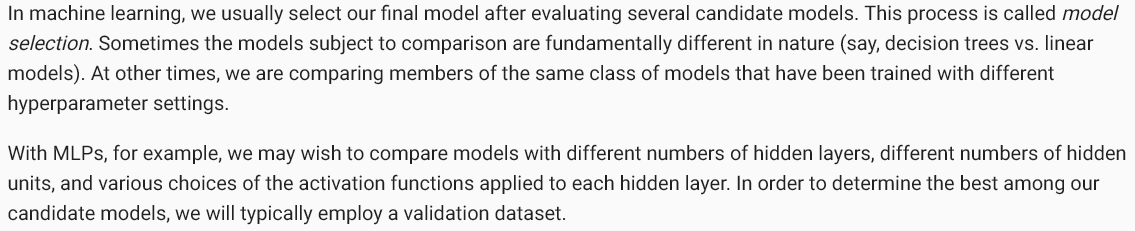

### A. Validation Dataset
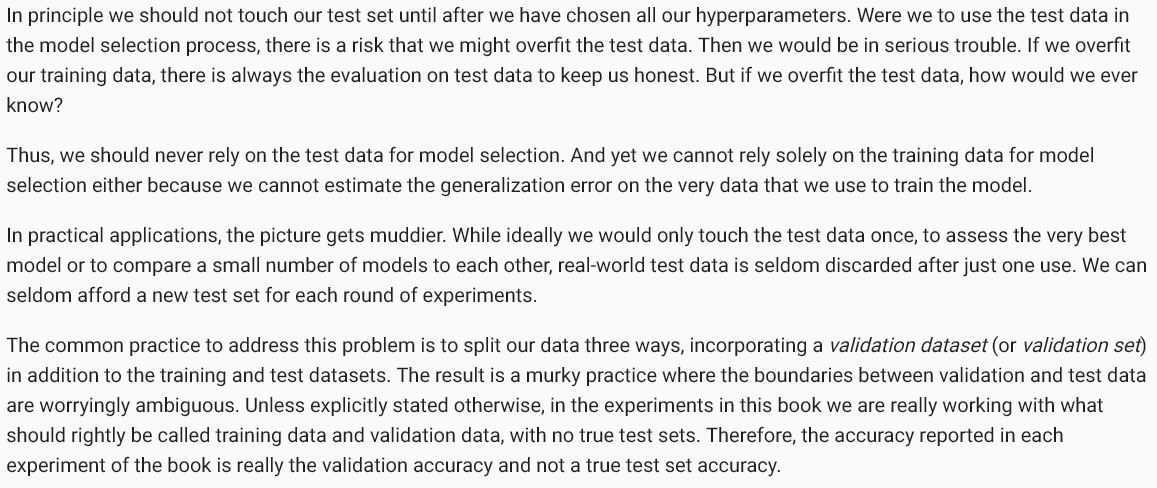
### B. K-Fold Cross-Validation
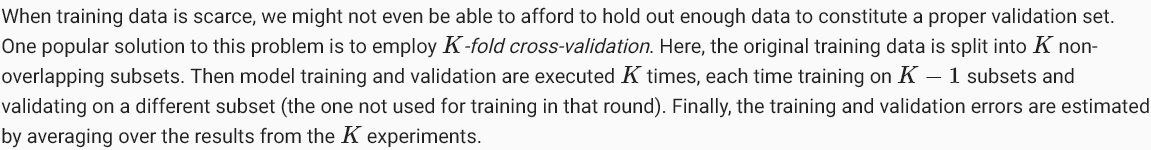

## 2. Underfitting or Overfitting
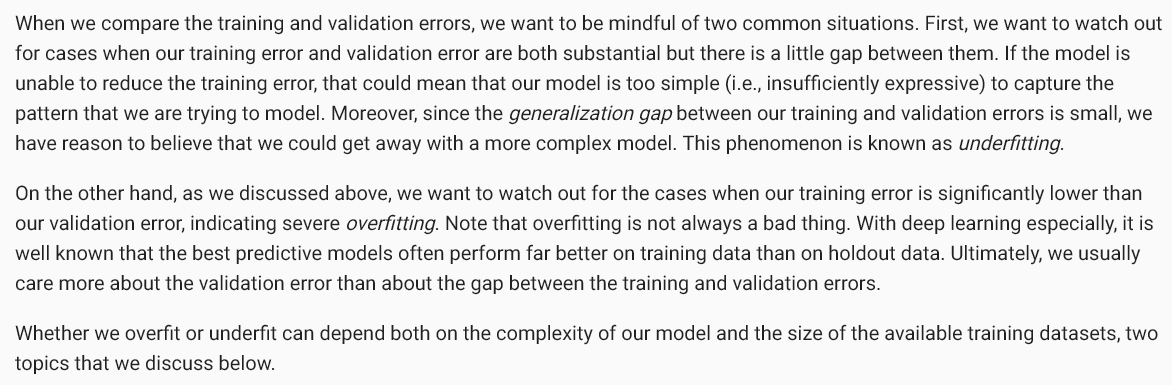

### a. Model Complexity
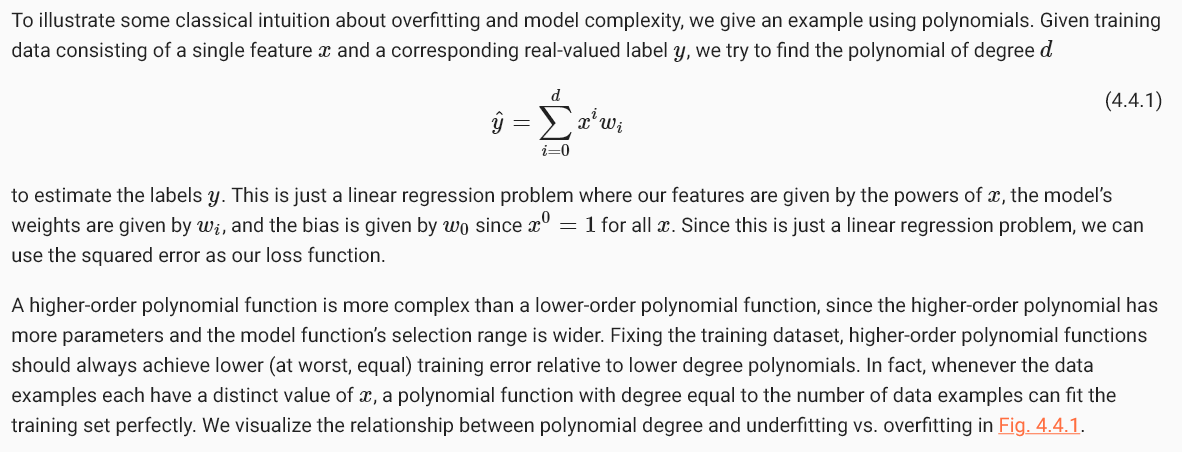
<img src="https://www.d2l.ai/_images/capacity-vs-error.svg"/>

### b. Dataset Size
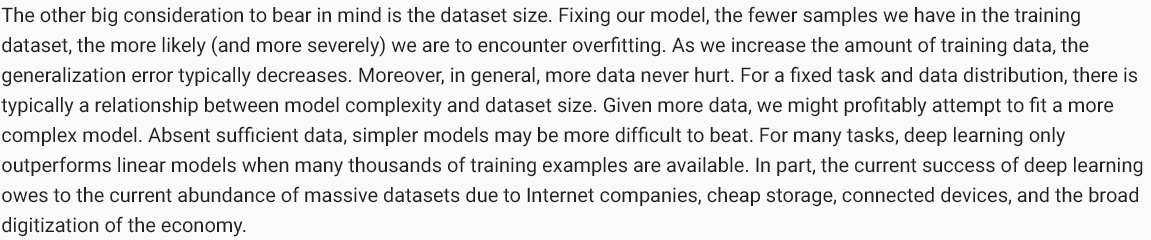

## Polynomial Regression
We can now explore these concepts interactively by fitting polynomials to data.

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### Generating the Dataset
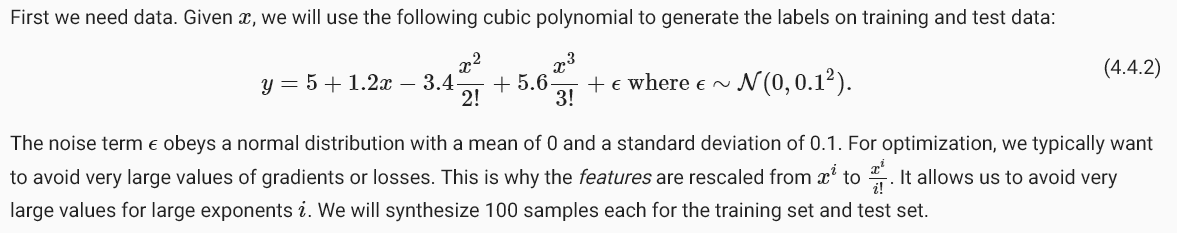

In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset
true_w = np.zeros(max_degree) # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) 

    
# Shape of `labels` : (n_train, n_test)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

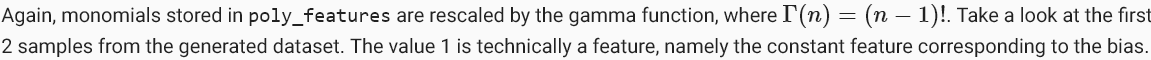

In [3]:
# Convert NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2465],
         [-0.6517]]),
 tensor([[ 1.0000e+00, -2.4648e-01,  3.0376e-02, -2.4957e-03,  1.5378e-04,
          -7.5810e-06,  3.1143e-07, -1.0966e-08,  3.3785e-10, -9.2527e-12,
           2.2806e-13, -5.1102e-15,  1.0496e-16, -1.9901e-18,  3.5037e-20,
          -5.7573e-22,  8.8691e-24, -1.2859e-25,  1.7608e-27, -2.2843e-29],
         [ 1.0000e+00, -6.5166e-01,  2.1233e-01, -4.6121e-02,  7.5138e-03,
          -9.7928e-04,  1.0636e-04, -9.9014e-06,  8.0654e-07, -5.8398e-08,
           3.8056e-09, -2.2545e-10,  1.2243e-11, -6.1370e-13,  2.8566e-14,
          -1.2410e-15,  5.0544e-17, -1.9375e-18,  7.0143e-20, -2.4057e-21]]),
 tensor([4.6367, 3.2830]))

## Train and Testing Model

In [8]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [9]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


### Third-Order Polynomial Function
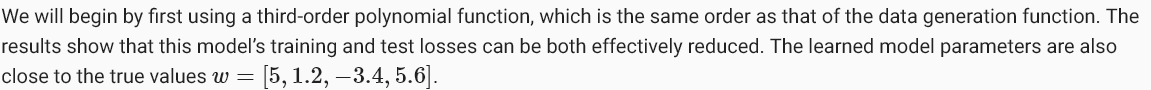

weight: [[ 5.0057154  1.2349725 -3.3922074  5.5318933]]


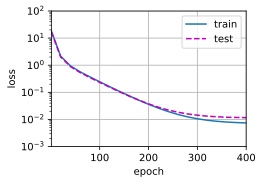

In [10]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## Linear Function Fitting (UnderFitting)
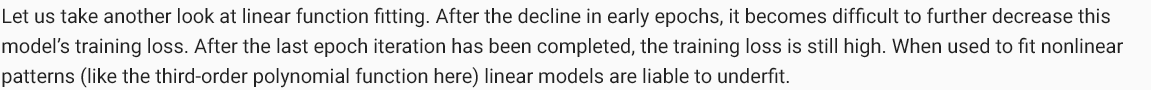

weight: [[3.585898  2.9635117]]


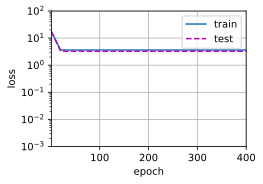

In [11]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## Higher-Order Polynomial Function Fitting (Overfitting)
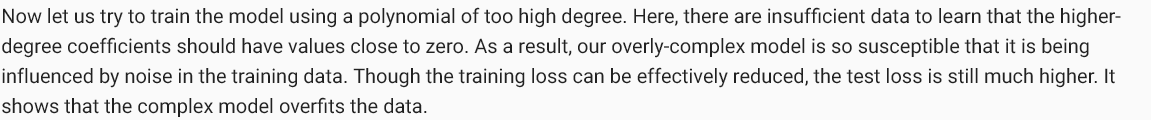

weight: [[ 4.997214    1.2492135  -3.3368714   5.31653    -0.2919145   1.1099273
   0.2225091   0.23289768  0.14307967 -0.0765427  -0.14445977  0.17785922
   0.01529137 -0.11067918  0.04495663  0.20927298 -0.14047532 -0.04780842
   0.21130249 -0.14400417]]


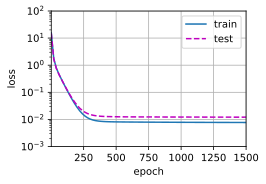

In [12]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)